In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK

# TensorFlow warning suppression
import os
import logging
#os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

params = {'font.size': 18,
          'axes.linewidth':1}
plt.rcParams.update(params)

## Importing Experimental Data (AME2016)

In [2]:
# Keeping relevant columns from AME2016 dataset 
data = pd.read_csv('EXPERIMENT_AME2016.dat', sep=r'\s+', usecols=['A', 'N', 'Z', 'E', 'E/A'])
data.tail()

,A,N,Z,E,E/A
3428,293,176,117,-2077.388399,-7.090063
3429,294,177,117,-2083.601399,-7.087080
3430,293,175,118,-2072.079974,-7.071945
3431,294,176,118,-2079.744974,-7.073962
3432,295,177,118,-2085.643974,-7.069980


## Finding SEMF parameters by data-fitting

In [3]:
# First add coefficients of each term in the formula to the dataset 
data['semf_surface'] = -data['A']**(2/3)
data['semf_coulomb'] = -data['Z']*(data['Z'] -1)/data['A']**(1/3)
data['semf_asymmetry'] = -(data['A'] - 2*data['Z'])**2/data['A']
data['semf_pairing'] = data['A']*0 

# Odd-even delta for pairing term
for i in data.index:
    mass_num = data.loc[i, 'A']
    if mass_num % 2 == 0:
        if data.loc[i, 'Z'] % 2 == 0:
            data.loc[i, 'semf_pairing'] = mass_num**(-0.5)
        elif data.loc[i, 'Z'] % 2 == 1: 
            data.loc[i, 'semf_pairing'] = -mass_num**(-0.5)

data.tail()

,A,N,Z,E,E/A,semf_surface,semf_coulomb,semf_asymmetry,semf_pairing
3428,293,176,117,-2077.388399,-7.090063,-44.114201,-2043.405906,-11.880546,0.000000
3429,294,177,117,-2083.601399,-7.087080,-44.214517,-2041.086487,-12.244898,-0.058321
3430,293,175,118,-2072.079974,-7.071945,-44.114201,-2078.637042,-11.088737,0.000000
3431,294,176,118,-2079.744974,-7.073962,-44.214517,-2076.277633,-11.442177,0.058321
3432,295,177,118,-2085.643974,-7.069980,-44.314720,-2073.928901,-11.800000,0.000000


In [36]:
# Convert into coefficient matrix 
coeff = np.asarray([data['A'], data['semf_surface'], data['semf_coulomb'],
    data['semf_asymmetry'], data['semf_pairing']])
# Transpose into columns
coeff = coeff.T
y = data['E']
# Linear regression to find parameters 
params = np.linalg.lstsq(coeff, y, rcond=None)[0]
params = params[:, np.newaxis]
np.shape(coeff)

(3433, 5)

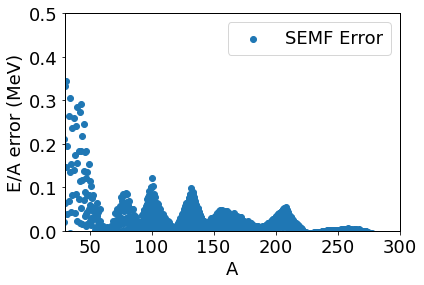

In [69]:
# Add SEMF predictions to dataset, plot comparison 
data['semf_E/A'] = np.matmul(coeff, params)/np.array(data['A'], ndmin = 2).T
plt.scatter(data['A'], (data['semf_E/A'] - data['E/A']), label='SEMF Error')
# Mass formula is more accurate for Z > 20, only plotting those
plt.xlim(30, 300)
plt.ylim(0, 0.5)
plt.xlabel('A')
plt.ylabel('E/A error (MeV)')
plt.legend()
plt.show()

## Creating Deep Neural Network

In [17]:
# Next, we design our model architecture to be optimized. Going with two hidden layers.   

def dnn_model(df, features, target, n_epochs, n_nodes, dropout_frac, function):
    x_features = df[features]
    y_target = df[target]
    batch_size = 64
    # Splitting into training/testing sets 
    x_train, x_test, y_train, y_test = train_test_split(x_features,y_target,train_size=0.8)
    # Creating normalizing object
    normalizer = tf.keras.layers.Normalization(axis=-1)
    # Normalizing inputs 
    normalizer.adapt(np.array(x_train))
    # Specifying model architecture 
    DNN_model = keras.Sequential([
      normalizer,
      layers.Dropout(dropout_frac),
      layers.Dense(n_nodes[0], activation=function),
      layers.Dropout(dropout_frac),
      layers.Dense(n_nodes[1], activation=function),
      layers.Dropout(dropout_frac),
      # Regression problem requires only one linear output unit
      layers.Dense(1)])
    DNN_model.compile(loss='mean_squared_error',
        optimizer=tf.keras.optimizers.Adam())
    # Training model 
    history=DNN_model.fit(x_train, y_train,
        batch_size=batch_size,
        epochs=n_epochs,
        verbose=0,
        validation_data=(x_test, y_test))
    # Performance metrics  
    train_score = r2_score(y_train, DNN_model.predict(x_train))
    test_score = r2_score(y_test, DNN_model.predict(x_test))
    print('Training Score:', train_score)
    print('Test Score:', test_score)
    # After training, predicting target from features 
    y_prediction = DNN_model.predict(x_features)
    #UNCOMMENT FOR HYPERPARAMETER OPTIMIZATION 
    #return train_score, test_score 
    #UNCOMMENT FOR PREDICTIONS
    return y_prediction

## Refining Architecture through Hyperparameter Optimization 

In [7]:
features = ['A', 'semf_surface', 'semf_coulomb', 'semf_asymmetry', 'semf_pairing']

# Creating function that trial runs the neural network for hyperparameter optimization
def dnn_evaluate(hyparms):
    n_nodes1 = int(hyparms['n_nodes1'])
    n_nodes2 = int(hyparms['n_nodes2'])
    nodes = [n_nodes1, n_nodes2]
    frac_dropout = float(hyparms['frac_dropout'])
    n_epochs = int(hyparms['n_epochs'])
    act_func = (hyparms['act_func'])
    model_score = dnn_model(data, features, 'E/A', n_epochs, nodes, frac_dropout, act_func)[1] #Define model
    return -model_score #Maximize R^2_test = Minimize (-R^2_test)

In [8]:
# Defining hyperparameter space to be explored by optimization
space = {
    'frac_dropout': hp.uniform('frac_dropout', 0., 0.5),
    'n_nodes1': hp.quniform('n_nodes1', 10,500,10),
    'n_nodes2': hp.quniform('n_nodes2', 10,500,10),
    'n_epochs': hp.quniform('n_epochs', 10,5000,10),
    'act_func': hp.choice('act_func',['relu','sigmoid', 'tanh'])
}

# Results object
trials = Trials()

In [ ]:
# Optimizing
besthyparms = fmin(dnn_evaluate, space, algo=tpe.suggest, max_evals=30, trials=trials)

print("R2_test",-trials.best_trial['result']['loss'])
print(besthyparms)

In [19]:
# Recording the best parameters from the optimization
act_func = 'relu'
frac_dropout = 0
n_epochs = 5000
nodes = [480, 50]

# Storing the neural network predictions into the dataset 
data['dnn_E/A'] = dnn_model(data, features, 'E/A', n_epochs, nodes, frac_dropout, act_func)

Training Score: 0.9973803389002375
Test Score: 0.9783825065806245


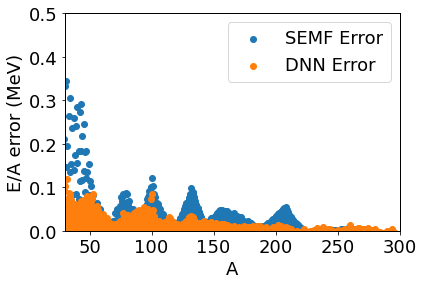

In [66]:
# Comparing error in mass predictions for both SEMF and neural network
plt.scatter(data['A'], (data['semf_E/A'] - data['E/A']), label='SEMF Error')
plt.scatter(data['A'], (data['dnn_E/A'] - data['E/A']), label='DNN Error')
plt.xlim(30, 300)
plt.ylim(0, 0.5)
plt.xlabel('A')
plt.ylabel('E/A error (MeV)')
plt.legend()
plt.show()